Using the Northwind database, an open-source dataset created by Microsoft, this Jupyter notebook will do some exploratory data analysis and use hypothesis testing to dive deep into four questions:
1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
2. Do discounts have a statistically significant effect on the dollar value of orders?
3. Do older customers have statistically significant larger value orders?
4. Do older customers have statistically significant larger order velocity (orders/time)?


Step 1: Import the libraries used.

In [345]:
#imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline

from math import sqrt
import scipy.stats as stats
from sklearn import preprocessing

from datetime import datetime
# import warnings
# warnings.filterwarnings("ignore")

Step 1: Create an sqalchemy "engine" to query the database tables.

In [2]:
# create the SQL engine
# optinal - to use the large version of the databse, use this to create the SQL engine:
# engine = create_engine('sqlite:///Northwind_large.sqlite', echo=True)

# using the small version of the databse:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
con = engine.connect()
Session = sessionmaker(bind=engine)
session = Session()

2019-05-15 07:07:38,047 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-15 07:07:38,048 INFO sqlalchemy.engine.base.Engine ()
2019-05-15 07:07:38,050 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-15 07:07:38,051 INFO sqlalchemy.engine.base.Engine ()


In [3]:
# have a look at the various tables
inspector = inspect(engine)
print(inspector.get_table_names())

2019-05-15 07:07:38,060 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-15 07:07:38,061 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


There are 13 tables. This chart shows the relationships between the tables.
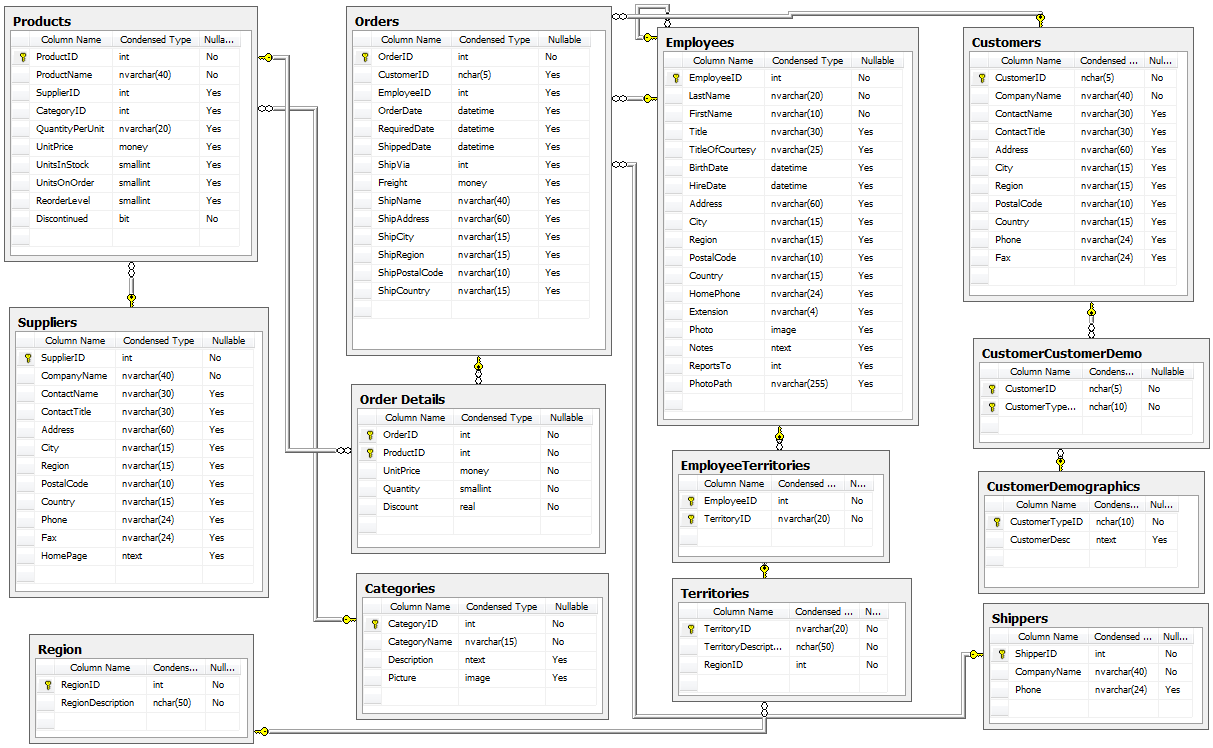

As I will be creating multiple pandas dataframes from the sql tables, I need a function that will return the column names from an SQL table.

In [4]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

In [5]:
#function to return a list of the column names from table given as an argument
def make_column_list(table):
    cols = []  #make an empty list
    cols_dict = inspector.get_columns(table)  # make a dict of the column names from the SQL table
#     print(cols_list)
    for column in cols_dict:
        cols.append(column['name'])
#     print(cols)
    return cols

In [6]:
# crate a pandas dataframe of the OrderDetail table
rs = con.execute('SELECT * FROM OrderDetail')
order_detail = pd.DataFrame(rs.fetchall())

column_names = make_column_list('OrderDetail')
order_detail.columns = column_names

order_detail.head()

2019-05-15 07:07:38,088 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-05-15 07:07:38,090 INFO sqlalchemy.engine.base.Engine ()
2019-05-15 07:07:38,104 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-05-15 07:07:38,105 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
# customer table to a pandas dataframe
rs = con.execute('SELECT * FROM Customer')
customers = pd.DataFrame(rs.fetchall())
column_names = make_column_list('Customer')
customers.columns = column_names

customers.head(10)

2019-05-15 07:07:38,137 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-05-15 07:07:38,139 INFO sqlalchemy.engine.base.Engine ()
2019-05-15 07:07:38,144 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-05-15 07:07:38,145 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745


In [8]:
# get full orders
rs = con.execute('SELECT * FROM [Order]')
orders = pd.DataFrame(rs.fetchall())

column_names = make_column_list('Order')
orders.columns = column_names

orders.head()

2019-05-15 07:07:38,170 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-05-15 07:07:38,172 INFO sqlalchemy.engine.base.Engine ()
2019-05-15 07:07:38,181 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-05-15 07:07:38,182 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


After some errors during EDA I discovered some orders with CustomerId's that did not exist in the Customers table:
* ANTO
* DUMO
* OCEA
* QUEE

Upon inspection of the Customers table, it appears that the above Id's are all missing an "N" at the end of the Id. As customer Id's have 5 letters except these 4, so I chose to assign these orders to the what reasonably appears to be the correct Customer, assuming that the last letter had somehow been deleted. 

In [9]:
# correct the incorect CustomerId values in orders_count
orders['CustomerId'].replace('ANTO', 'ANTON', inplace=True)
orders['CustomerId'].replace('DUMO', 'DUMON', inplace=True)
orders['CustomerId'].replace('OCEA', 'OCEAN', inplace=True)
orders['CustomerId'].replace('QUEE', 'QUEEN', inplace=True)
orders.sort_values('CustomerId').groupby('CustomerId').groups

{'ALFKI': Int64Index([763, 444, 454, 587, 704, 395], dtype='int64'),
 'ANATR': Int64Index([511, 678, 377, 60], dtype='int64'),
 'ANTON': Int64Index([608, 117, 287, 325, 259, 434, 429], dtype='int64'),
 'AROUT': Int64Index([135, 520, 205, 616, 495, 310, 493, 459, 705, 768, 107, 672, 545], dtype='int64'),
 'BERGS': Int64Index([627, 406, 618, 676, 441, 485, 424, 378, 530, 609,  32, 276, 324,
              30, 197, 136, 196, 589],
            dtype='int64'),
 'BLAUS': Int64Index([366, 708, 261, 605, 334, 810, 253], dtype='int64'),
 'BLONP': Int64Index([112, 578, 49, 17, 311, 318, 336, 431, 201, 380, 188], dtype='int64'),
 'BOLID': Int64Index([78, 553, 722], dtype='int64'),
 'BONAP': Int64Index([ 83, 222, 692, 828,  92, 263, 114, 684, 415, 277, 579, 507, 484,
             623, 628, 467, 482],
            dtype='int64'),
 'BOTTM': Int64Index([162, 701, 696, 670, 800, 244, 494, 183, 727, 797, 734, 163, 779,
             141],
            dtype='int64'),
 'BSBEV': Int64Index([291, 290, 699, 23

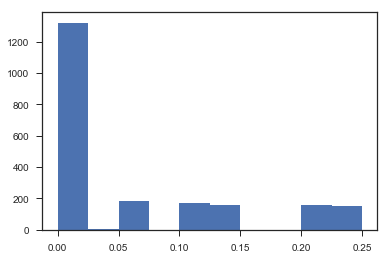

In [10]:
# an initial look at how product line items in the orders are distributed based on any discounts
plt.hist(order_detail["Discount"])
plt.show()

The vast majority of products ordered have no discount.
For ordered products that had a discount applied, the distribution into different levels of discount looks roughly equal.

The order_detail dataframe does not have any totals so I created a total for each line as that value would appear on the actual order.

In [11]:
# make a new column to calculate the line item total
order_detail['line_total'] = order_detail['Quantity'] * order_detail['UnitPrice'] * (1 - order_detail['Discount'])

order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [12]:
# a little more EDA, how many orders had at least one product discounted?
rs = con.execute('SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0')

orders_with_discount = pd.DataFrame(rs.fetchall())

orders_with_discount.columns = ['Id']

orders_with_discount.count()

2019-05-15 07:07:38,767 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0
2019-05-15 07:07:38,770 INFO sqlalchemy.engine.base.Engine ()


Id    380
dtype: int64

380 orders had at least one discounted product. How many orders had no discounts?

In [13]:
# make a list of orders that have no discounted items
orders_without_discount = orders.merge(orders_with_discount.drop_duplicates(), on=['Id'], how='left', indicator=True)

orders_without_discount = orders_without_discount[orders_without_discount._merge != 'both']

orders_without_discount.count()

Id                450
CustomerId        450
EmployeeId        450
OrderDate         450
RequiredDate      450
ShippedDate       440
ShipVia           450
Freight           450
ShipName          450
ShipAddress       450
ShipCity          450
ShipRegion        450
ShipPostalCode    446
ShipCountry       450
_merge            450
dtype: int64

450 orders had no discounted items. Just to check the totals, I checked the total number of orders.

In [14]:
len(orders)

830

450 orders with no discount plus 380 orders that had a discount equals 830 total orders. Now checking for any missing values in the orders table. 

In [15]:
orders.count()

Id                830
CustomerId        830
EmployeeId        830
OrderDate         830
RequiredDate      830
ShippedDate       809
ShipVia           830
Freight           830
ShipName          830
ShipAddress       830
ShipCity          830
ShipRegion        830
ShipPostalCode    811
ShipCountry       830
dtype: int64

* 19 orders have no value for ShipPostalCode.
* 21 orders have no value for ShippedDate.

To investigate the first question:

**_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_**

I added four new columns to the orders table:
* order_total
* unique_products_count
* all_items_total_qty_count
* discount_flag


In [16]:
# add blank columns to orders dataframe
orders['order_total'] = 0
orders['unique_products_count'] = 0
orders['all_items_total_qty_count'] = 0
orders['discount_flag'] = False #True if order contains any discounted items, otherwise False

orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,0,0,0,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,0,0,0,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,0,0,0,False
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,0,0,0,False
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,0,0,0,False


In [17]:
# populate the new columns

for index, row in orders.iterrows():
    order_id = row['Id']     #row['Id'] gets the OrderId column value
    order_index = index
    
# get the relevant rows from order_detail
    temp_df = order_detail.loc[order_detail['OrderId'] == order_id]
    
    #clear the variables
    order_total = 0
    order_product_ids_count = 0
    product_ids = []
    all_items_total_qty_count = 0
    discount_flag = False
    
    # iterate through the order_detail rows and calculate the values
    for index, row in temp_df.iterrows():
        order_total += round((row['UnitPrice'] * row['Quantity']) * (1 - row['Discount']),2)
        product_ids.append(row['ProductId'])  #get the unique product id's
        all_items_total_qty_count += row['Quantity'] #count up the total # of units of all products in the order

    #check if any discount, if yes skip for this row, otherwise check if the current row has a discount
        if discount_flag == False:
            if row['Discount'] > 0:
                discount_flag = True
    
    product_ids = set(product_ids)     #make a set (unique values only) of the product id's
    
# add these values to the order in the orders dataframe
    orders.iloc[order_index, orders.columns.get_loc('order_total')] = order_total
    orders.iloc[order_index, orders.columns.get_loc('unique_products_count')] = len(product_ids)
    orders.iloc[order_index, orders.columns.get_loc('all_items_total_qty_count')] = all_items_total_qty_count
    orders.iloc[order_index, orders.columns.get_loc('discount_flag')] = discount_flag


In [18]:
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.00,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.40,2,49,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True


I then split the orders table into two tables, one for orders with a discount and one for orders without a discount and checked to make sure the length of the tables matched the original SQL tables.


In [19]:
discount = orders[orders['discount_flag'] == True]
len(discount)

380

In [20]:
no_discount = orders[orders['discount_flag'] == False]
len(no_discount)

450

I wanted to first look at a scatter plot comparing orders with and without a discount.

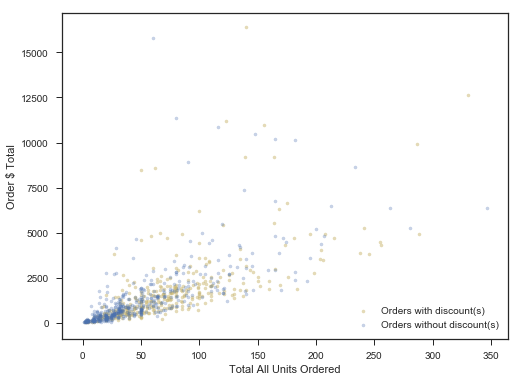

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(discount['all_items_total_qty_count'], discount['order_total'], s=10, c='y', alpha=.5, label='Orders with discount(s)')
ax.scatter(no_discount['all_items_total_qty_count'], no_discount['order_total'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Total All Units Ordered")
ax.set_ylabel("Order $ Total")
plt.legend(loc='lower right')

There does appear to be a correlation where orders wtih a discount tend to have a higher total units ordered. To investigate further, I need to look at the level of discount present. To do this I will need to look at the order_details table.

I could take each product in of the order_detail table and calculate the average units ordered per each level of discount. Much harder would be to do this for each individual product.

In [22]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


Assign each product line item to one of four discount groups:
* 1 = discount less than 5% or no discount
* 2 = discount equal to or greater than 5% but less than 10%
* 3 = discount equal to or greater than 10% but less than 20%
* 4 = discount equal to or greater than 20%

In [23]:
#create the new column and fill it with zero's
order_detail['discount_group'] = 0

#iterate through the dataframe and assign each line to the correct group
for index, row in order_detail.iterrows():
#     x = order_detail.columns.get_loc('discount_group')
#     print(x)
#     break
    if row['Discount'] < 0.05:
        order_detail.iloc[index, 7] = 1
    if row['Discount'] >= 0.05 and row['Discount'] < 0.10:
        order_detail.iloc[index, 7] = 2
    if row['Discount'] >= .1 and row['Discount'] < 0.2:
        order_detail.iloc[index, 7] = 3
    if row['Discount'] >= 0.2:
        order_detail.iloc[index, 7] = 4


In [24]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
0,10248/11,10248,11,14.0,12,0.0,168.0,1
1,10248/42,10248,42,9.8,10,0.0,98.0,1
2,10248/72,10248,72,34.8,5,0.0,174.0,1
3,10249/14,10249,14,18.6,9,0.0,167.4,1
4,10249/51,10249,51,42.4,40,0.0,1696.0,1


In [25]:
grouped = order_detail.groupby('discount_group')
print (grouped['Quantity'].agg(np.mean))


discount_group
1    21.609517
2    27.870968
3    26.733333
4    27.619048
Name: Quantity, dtype: float64


Orders with a discount have a significantly higher mean quantity ordered than orders with a discount less than 5%


In [26]:
print(grouped['line_total'].agg(np.mean))

discount_group
1    567.210544
2    793.985454
3    542.440342
4    597.205306
Name: line_total, dtype: float64


Orders with a discounts in category 2 and 4 have higher mean quantity ordered than orders in groups 1 and 3.

Make a scatter chart to further explore these relationships.


In [27]:
order_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 8 columns):
Id                2155 non-null object
OrderId           2155 non-null int64
ProductId         2155 non-null int64
UnitPrice         2155 non-null float64
Quantity          2155 non-null int64
Discount          2155 non-null float64
line_total        2155 non-null float64
discount_group    2155 non-null int64
dtypes: float64(3), int64(4), object(1)
memory usage: 134.8+ KB


In [28]:
order_detail['discount_group'] = pd.Categorical(order_detail['discount_group'])
print (order_detail.dtypes)

Id                  object
OrderId              int64
ProductId            int64
UnitPrice          float64
Quantity             int64
Discount           float64
line_total         float64
discount_group    category
dtype: object


In [29]:
temp = [('1',21.609517),('2',27.870968),('3',26.733333),('4',27.619048)]
temp_df = pd.DataFrame(temp, columns=['discount_group', 'mean_quantity'])
temp_df.head()

,discount_group,mean_quantity
0,1,21.609517
1,2,27.870968
2,3,26.733333
3,4,27.619048


<BarContainer object of 4 artists>

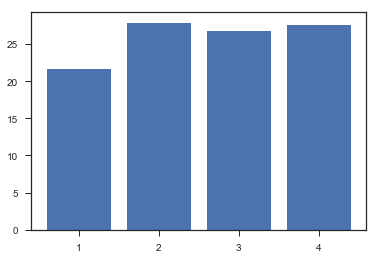

In [30]:
plt.bar(x='discount_group', height='mean_quantity', data=temp_df, align='center')

The average quantity ordered appears to be similarly higher for each category of discount, as compared to products with a less than 5% discount.

<BarContainer object of 4 artists>

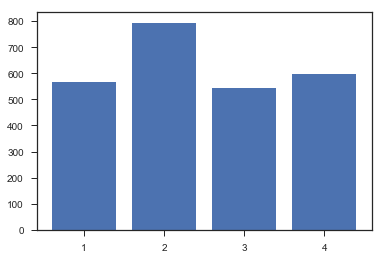

In [31]:
# bar chart of line_total by discount_category
temp = [('1',567.210544),('2',793.985454),('3',542.440342),('4',597.205306)]
temp_df = pd.DataFrame(temp, columns=['discount_group', 'line_total'])
# temp_df.head()
plt.bar(x='discount_group', height='line_total', data=temp_df, align='center')

It looks like products ordered with a discount_category of 2 generate the largest mean dollar amount.

Discount category 2 = discounts of at least 5% but less than 10%.

In [32]:
# make a temp dataframe of only the rows with a discount of 5% or more
temp_df = order_detail[order_detail['discount_group'] != 1]
temp_df.head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
6,10250/51,10250,51,42.4,35,0.15,1261.40,3
7,10250/65,10250,65,16.8,15,0.15,214.20,3
8,10251/22,10251,22,16.8,6,0.05,95.76,2
9,10251/57,10251,57,15.6,15,0.05,222.30,2
11,10252/20,10252,20,64.8,40,0.05,2462.40,2


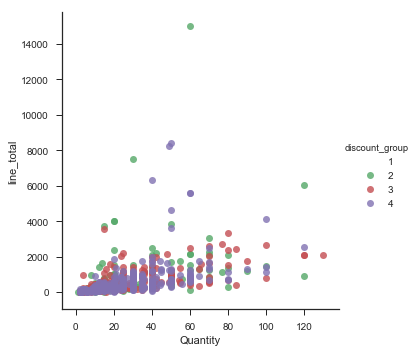

In [33]:
sns.lmplot('Quantity', 'line_total', data=temp_df, hue='discount_group', fit_reg=False)

In [34]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
0,10248/11,10248,11,14.0,12,0.0,168.0,1
1,10248/42,10248,42,9.8,10,0.0,98.0,1
2,10248/72,10248,72,34.8,5,0.0,174.0,1
3,10249/14,10249,14,18.6,9,0.0,167.4,1
4,10249/51,10249,51,42.4,40,0.0,1696.0,1


Hypothesis test #1:

Ho: There is no difference in the mean quantity ordered of products with a discount of 5% or more as compared to with a discount of less than 5%.

Ha: The mean quantity of products ordered with a discount of 5% or more is higher than products ordered with a discount of less than 5%.

In [185]:
mean_with_discount = np.mean(order_detail[order_detail['Discount'] >= 0.05]['Quantity'])
mean_with_discount

27.323706377858002

In [186]:
# get the number of rows that have a discount of 5% or greater
len(order_detail[order_detail['Discount'] >= 0.05])


831

In [187]:
mean_without_discount = np.mean(order_detail[order_detail['Discount'] < 0.05]['Quantity'])
mean_without_discount

21.6095166163142

In [188]:
# get the numer of rows that have a discount less than 0.05
len(order_detail[order_detail['Discount'] < 0.05])

1324

In [189]:
len(order_detail)

2155

In [190]:
actual_difference = mean_with_discount - mean_without_discount
actual_difference

5.714189761543803

In [191]:
def permutation_samples(key_value_list, no_of_trials, sample_size, column):
    difference_of_means = []

    while len(difference_of_means) < no_of_trials:
        temp_keys = key_value_list.index.values
        treatment_keys = np.random.choice(temp_keys, sample_size, replace=False)

        treatment = key_value_list[key_value_list.index.isin(treatment_keys)]
        control = key_value_list[~key_value_list.index.isin(treatment_keys)]

        # actual difference, positive or negative
        difference = np.mean(treatment[column]) -  np.mean(control[column])
        difference_of_means.append(difference)

#         print('difference value added:', abs_difference)
    return(difference_of_means)

/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


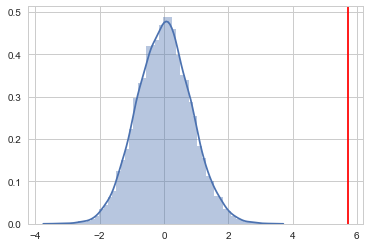

In [192]:
permutation_list = permutation_samples(order_detail, 10000, 831, 'Quantity')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

Clearly the observed mean difference of the quantity ordered between products with a discount and without a discount is extremely unlikely to be from chance. 

In [197]:
stats.normaltest(permutation_list)


NormaltestResult(statistic=4.657446832717231, pvalue=0.09742003256216547)

In [198]:
stats.kurtosistest(permutation_list)


KurtosistestResult(statistic=1.481811397717004, pvalue=0.1383904855196952)

/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


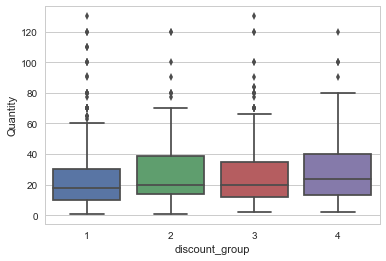

In [201]:
# look at bar charts of discount levels
sns.set_style("whitegrid") 
  
sns.boxplot(x = 'discount_group', y = 'Quantity', data = order_detail)


/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


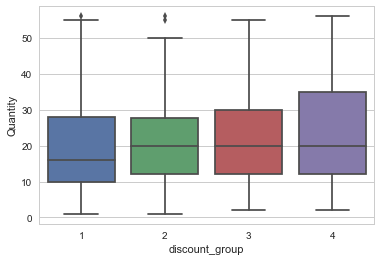

In [202]:
#there are many outliers in all discount_groups. I chose to eliminate all outliers at the top 5% of values.
quantile = order_detail['Quantity'].quantile(0.95)
temp_df = order_detail[order_detail['Quantity'] < quantile]
sns.boxplot(x = 'discount_group', y = 'Quantity', data = temp_df)

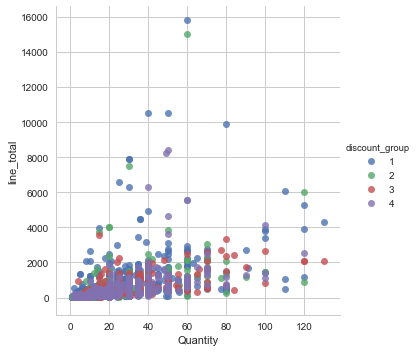

In [203]:
sns.lmplot( x='Quantity', y='line_total', data=order_detail, fit_reg=False, hue='discount_group', legend=True)
 


Hypothesis test #2:

Ho: There is no difference in the dollar amount ordered of products with a discount of 5% or more as compared to with a discount of less than 5%.

Ha: The mean dollar amount of products ordered with a discount of 5% or more is higher than products ordered with a discount of less than 5%.

In [204]:
mean_with_discount = np.mean(order_detail[order_detail['Discount'] >= 0.05]['line_total'])
mean_with_discount

619.5021407942237

From my analysis above I know there are 831 lines that match this criteria.
Now look at the mean line total for the lines with a discount of less than 5%.


In [205]:
mean_without_discount = np.mean(order_detail[order_detail['Discount'] < 0.05]['line_total'])
mean_without_discount

567.2105441842901

Again from above, I know there are 1,324 lines with a discount of less than 5%. After calculating the actual difference between these two groups, I will run another test using permutations to see how likely it is to get the difference observed.

In [206]:
actual_difference = mean_with_discount - mean_without_discount
actual_difference

52.29159660993355

/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


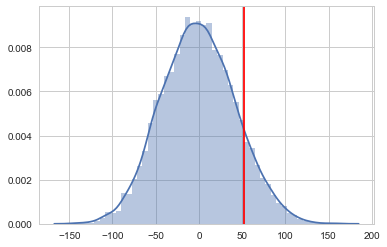

In [207]:
permutation_list = permutation_samples(order_detail, 10000, 831, 'line_total')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

In [208]:
stats.normaltest(permutation_list)

NormaltestResult(statistic=16.777909050336994, pvalue=0.00022736485838201458)

In [209]:
stats.kurtosistest(permutation_list)

KurtosistestResult(statistic=-1.9866906665791166, pvalue=0.04695668675775299)

In [210]:
# calculate the p-value for 
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > 52.28)
p_value = count/10000
p_value

0.1118

Out of 10,000 random samples of size 831, 1,158 had a difference of more than 52.28. 
Given that the difference in the random samples is very close to a normal distribution, there is an 11.58% chance
that the results could have been obtained randomly. We cannot reject the null hypothesis.

Hypothesis test #3:

Ho: There is no difference in the average order dollar amount for the oldest 50% of customers as compared to the youngest 50% of customers.

Ha: The average order dollar amount for the oldest 50% of customers is larger as compared to the youngest 50% of customers.

I added five new columns to the customers table:
    * total number of orders
    * total $ value of all orders
    * first order date
    * last order date
    * average orders/month (year?, etc.)


In [211]:
# add columns to customer dataframe: orders_count, orders_value, first_order_date, last_order_date
customers['orders_count'] = 0
customers['orders_value'] = 0
customers['order_avg'] = 0
customers['first_order_date'] = 0
customers['last_order_date'] = 0

# cast date columns as pandas datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers.head()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,0,0,1970-01-01,1970-01-01,0,0.009752
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,0,0,1970-01-01,1970-01-01,0,0.030934
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,0,0,1970-01-01,1970-01-01,0,0.026586
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,0,0,1970-01-01,1970-01-01,0,0.027331
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,0,0,1970-01-01,1970-01-01,0,0.033232


In [212]:
#get orders count
orders_count = orders.groupby("CustomerId")["Id"].nunique()
orders_count.head(10)

CustomerId
ALFKI     6
ANATR     4
ANTON     7
AROUT    13
BERGS    18
BLAUS     7
BLONP    11
BOLID     3
BONAP    17
BOTTM    14
Name: Id, dtype: int64

In [213]:
orders_count = orders_count.reset_index()
# orders_count.describe()
orders_count.head(10)

,CustomerId,Id
0,ALFKI,6
1,ANATR,4
2,ANTON,7
3,AROUT,13
4,BERGS,18
5,BLAUS,7
6,BLONP,11
7,BOLID,3
8,BONAP,17
9,BOTTM,14


In [214]:
orders_count.rename(columns={'Id':'order_count'}, inplace=True)
orders_count.head()

,CustomerId,order_count
0,ALFKI,6
1,ANATR,4
2,ANTON,7
3,AROUT,13
4,BERGS,18


In [215]:
orders_count.describe()

,order_count
count,89.000000
mean,9.325843
std,5.810991
min,1.000000
25%,5.000000
50%,8.000000
75%,12.000000
max,31.000000


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Distribution of the Number of Orders per Customer')

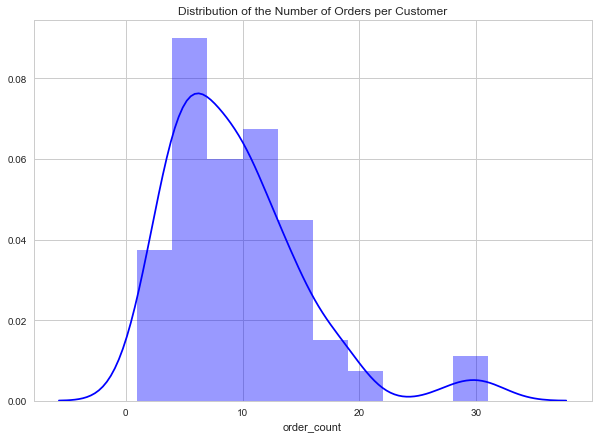

In [216]:
plt.figure(figsize=(10,7))

sns.distplot(orders_count['order_count'], color="blue",)
plt.title("Distribution of the Number of Orders per Customer")

In [217]:
# add order count to each customer record

for index, row in orders_count.iterrows():
    customer_id = row['CustomerId']
    order_count = row['order_count']
    customer_index = "NONE"
    
    # all customer id's in the customer table had five digits
    # this if/else statement was used to identify orders where the customer id was not five digits long
    if len(customer_id) == 5:                               
        customer_index = customers.loc[customers['Id'] == customer_id].index
        customers.iloc[customer_index, customers.columns.get_loc('orders_count')] = order_count
    else:
        print('CustomerId: {}'.format(customer_id))
        print('Order Count: {}'.format(order_count))
        print('Customer Index: {}'.format(customer_index))

In [218]:
#calculate customers total value of all orders
orders_total = orders.groupby("CustomerId")['order_total'].agg(sum)

orders_total = orders_total.reset_index()
orders_total.head()

,CustomerId,order_total
0,ALFKI,4273.00
1,ANATR,1402.95
2,ANTON,7023.98
3,AROUT,13390.65
4,BERGS,24927.58


In [219]:
# add the total value of all orders to each customer
for index, row in orders_total.iterrows():
    customer_id = row['CustomerId']
    order_total = row['order_total']
    customer_index = customers.loc[customers['Id'] == customer_id].index
    customers.iloc[customer_index,customers.columns.get_loc('orders_value')] = order_total

In [220]:
customers.head(10)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,1970-01-01,1970-01-01,0,0.009752
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,1970-01-01,1970-01-01,0,0.030934
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,1970-01-01,1970-01-01,0,0.026586
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,1970-01-01,1970-01-01,0,0.027331
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,1970-01-01,1970-01-01,0,0.033232
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924,7,3239.80,1970-01-01,1970-01-01,0,0.018324
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32,11,18534.08,1970-01-01,1970-01-01,0,0.034350
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99,3,4232.85,1970-01-01,1970-01-01,0,0.029567
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41,17,21963.24,1970-01-01,1970-01-01,0,0.029194
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745,14,20801.59,1970-01-01,1970-01-01,0,0.025157


In [221]:
customers.describe()

,orders_count,orders_value,order_avg,scaled_customer_age
count,91.000000,91.000000,91.0,91.000000
mean,9.120879,13909.813297,0.0,0.049013
std,5.908253,20103.531743,0.0,0.143556
min,0.000000,0.000000,0.0,0.000000
25%,5.000000,3166.755000,0.0,0.025219
50%,8.000000,7023.980000,0.0,0.029940
75%,12.000000,16646.830000,0.0,0.033791
max,31.000000,110277.320000,0.0,1.000000


In [222]:
# inspect the count of orders for customers

order_counts = customers.groupby('orders_count')['orders_count'].count()
order_counts

orders_count
0      2
1      1
2      2
3      7
4      6
5     10
6      8
7      7
8      4
9      5
10    11
11     4
12     3
13     3
14     6
15     3
17     1
18     3
19     2
28     1
30     1
31     1
Name: orders_count, dtype: int64

Two customers have no order, one customer has only one order.

In [121]:
under_two_orders = customers.loc[customers['orders_count'] < 2]
print (under_two_orders)

       Id                           CompanyName      ContactName  \
12  CENTC            Centro comercial Moctezuma  Francisco Chang   
21  FISSA  FISSA Fabrica Inter. Salchichas S.A.       Diego Roel   
56  PARIS                     Paris spécialités   Marie Bertrand   

          ContactTitle                  Address         City           Region  \
12   Marketing Manager  Sierras de Granada 9993  México D.F.  Central America   
21  Accounting Manager       C/ Moralzarzal, 86       Madrid  Southern Europe   
56               Owner  265, boulevard Charonne        Paris   Western Europe   

   PostalCode Country            Phone              Fax  orders_count  \
12      05022  Mexico     (5) 555-3392     (5) 555-7293             1   
21      28034   Spain   (91) 555 94 44   (91) 555 55 93             0   
56      75012  France  (1) 42.34.22.66  (1) 42.34.22.77             0   

    orders_value first_order_date last_order_date  order_avg  
12         100.8       1970-01-01      1970-01

In [223]:
#get first and last order dates
# order_dates = orders.groupby("CustomerId")['OrderDate']

for index, row in customers.iterrows():
    #iterrate through customers list
    #set first and last order date variables, cast as time_date
    first_order_date = np.NaN
    last_order_date = np.NaN
    first_order_date = pd.to_datetime(first_order_date)
    last_order_date = pd.to_datetime(last_order_date)

    # get current customer id
    customer_id = row['Id']
    temp_list = []
    # iterrate through orders
    for index, row in orders.iterrows():
        if row['CustomerId'] == customer_id:
            temp_list.append(row['OrderDate'])
#     print(temp_list)
    temp_list.sort()
    customer_index = customers.loc[customers['Id'] == customer_id].index
    
    if len(temp_list) == 0: #flag to see if any customers have no orders
        print('No order found for customer: {}'.format(customer_id))
        
    if len(temp_list) == 1: #handle the case where there is only one order
        print('Customer: {} has only one order.'.format(customer_id))
        temp_date = temp_list.pop(0)
        customers.iloc[customer_index, customers.columns.get_loc('first_order_date')] = temp_date
        customers.iloc[customer_index, customers.columns.get_loc('last_order_date')] = temp_date
        
    if temp_list: # case there there is more than one order
        customers.iloc[customer_index, customers.columns.get_loc('first_order_date')] = temp_list.pop(0)
        customers.iloc[customer_index, customers.columns.get_loc('last_order_date')] = temp_list.pop(-1)
    

Customer: CENTC has only one order.
No order found for customer: FISSA
No order found for customer: PARIS


In [224]:
customers.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,2013-08-25,2014-04-09,0,0.009752
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,2012-09-18,2014-03-04,0,0.030934
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,2012-11-27,2014-01-28,0,0.026586
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,2012-11-15,2014-04-10,0,0.027331
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,2012-08-12,2014-03-04,0,0.033232


In [225]:
# create some columns: average value of each customers orders, age of customer
# cast date columns as datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers['order_avg'] = customers['orders_value'] / customers['orders_count']
today = pd.to_datetime('today')
customers['scaled_customer_age'] = (today - customers['first_order_date']).dt.days

customers.sort_values(['scaled_customer_age'])

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
39,LACOR,La corne d'abondance,Daniel Tonini,Sales Representative,"67, avenue de l'Europe",Versailles,Western Europe,78000,France,30.59.84.10,30.59.85.11,4,1992.05,2014-01-29,2014-03-24,498.012500,1932
73,SPECD,Spécialités du monde,Dominique Perrier,Marketing Manager,"25, rue Lauriston",Paris,Western Europe,75016,France,(1) 47.55.60.10,(1) 47.55.60.20,4,2423.35,2013-11-12,2014-04-22,605.837500,2010
25,FRANR,France restauration,Carine Schmitt,Marketing Manager,"54, rue Royale",Nantes,Western Europe,44000,France,40.32.21.21,40.32.21.20,3,3172.16,2013-09-17,2014-03-24,1057.386667,2066
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,2013-08-25,2014-04-09,712.166667,2089
77,THECR,The Cracker Box,Liu Wong,Marketing Assistant,55 Grizzly Peak Rd.,Butte,North America,59801,USA,(406) 555-5834,(406) 555-8083,3,1947.24,2013-08-07,2014-04-06,649.080000,2107
89,WILMK,Wilman Kala,Matti Karttunen,Owner/Marketing Assistant,Keskuskatu 45,Helsinki,Scandinavia,21240,Finland,90-224 8858,90-224 8858,7,3161.35,2013-07-30,2014-04-07,451.621429,2115
44,LETSS,Let's Stop N Shop,Jaime Yorres,Owner,87 Polk St. Suite 5,San Francisco,North America,94117,USA,(415) 555-5938,None,4,3076.47,2013-06-25,2014-02-12,769.117500,2150
81,TRAIH,Trail's Head Gourmet Provisioners,Helvetius Nagy,Sales Associate,722 DaVinci Blvd.,Kirkland,North America,98034,USA,(206) 555-8257,(206) 555-2174,3,1571.20,2013-06-19,2014-01-08,523.733333,2156
49,MAISD,Maison Dewey,Catherine Dewey,Sales Agent,Rue Joseph-Bens 532,Bruxelles,Western Europe,B-1180,Belgium,(02) 201 24 67,(02) 201 24 68,7,9736.07,2013-05-07,2014-04-07,1390.867143,2199
31,GREAL,Great Lakes Food Market,Howard Snyder,Marketing Manager,2732 Baker Blvd.,Eugene,North America,97403,USA,(503) 555-7555,None,11,18507.46,2013-05-06,2014-04-30,1682.496364,2200


In [226]:
# normalize customer_age
x = customers[['scaled_customer_age']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

customers['scaled_customer_age'] = x_scaled


# https://chrisalbon.com/python/data_wrangling/pandas_normalize_column/

In [227]:
customers.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,2013-08-25,2014-04-09,712.166667,0.009752
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,2012-09-18,2014-03-04,350.737500,0.030934
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,2012-11-27,2014-01-28,1003.425714,0.026586
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,2012-11-15,2014-04-10,1030.050000,0.027331
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,2012-08-12,2014-03-04,1384.865556,0.033232


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Distribution of scaled_customer_age')

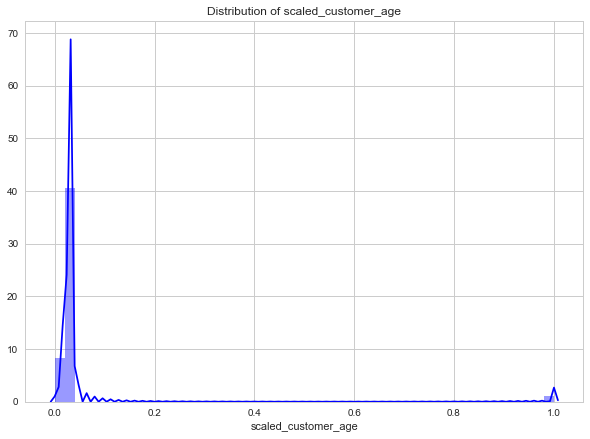

In [228]:
plt.figure(figsize=(10,7))

sns.distplot(customers['scaled_customer_age'], color="blue",)
plt.title("Distribution of scaled_customer_age")

In [321]:
# look at the outliers
temp = customers.loc[customers['orders_count'] < 4]
temp.head(10)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99,3,4232.85,2012-10-10,2014-03-24,1410.950000,0.029567
12,CENTC,Centro comercial Moctezuma,Francisco Chang,Marketing Manager,Sierras de Granada 9993,México D.F.,Central America,05022,Mexico,(5) 555-3392,(5) 555-7293,1,100.80,2012-07-18,2012-07-18,100.800000,0.034785
15,CONSH,Consolidated Holdings,Elizabeth Brown,Sales Representative,Berkeley Gardens 12 Brewery,London,British Isles,WX1 6LT,UK,(171) 555-2282,(171) 555-9199,3,1719.10,2013-02-04,2014-01-23,573.033333,0.022300
21,FISSA,FISSA Fabrica Inter. Salchichas S.A.,Diego Roel,Accounting Manager,"C/ Moralzarzal, 86",Madrid,Southern Europe,28034,Spain,(91) 555 94 44,(91) 555 55 93,0,0.00,1970-01-01,1970-01-01,NaN,1.000000
25,FRANR,France restauration,Carine Schmitt,Marketing Manager,"54, rue Royale",Nantes,Western Europe,44000,France,40.32.21.21,40.32.21.20,3,3172.16,2013-09-17,2014-03-24,1057.386667,0.008323
32,GROSR,GROSELLA-Restaurante,Manuel Pereira,Owner,5ª Ave. Los Palos Grandes,Caracas,South America,1081,Venezuela,(2) 283-2951,(2) 283-3397,2,1488.70,2012-07-30,2013-12-18,744.350000,0.034039
41,LAUGB,Laughing Bacchus Wine Cellars,Yoshi Tannamuri,Marketing Assistant,1900 Oak St.,Vancouver,North America,V3F 2K1,Canada,(604) 555-3392,(604) 555-7293,3,522.50,2013-04-03,2014-01-01,174.166667,0.018697
42,LAZYK,Lazy K Kountry Store,John Steel,Marketing Manager,12 Orchestra Terrace,Walla Walla,North America,99362,USA,(509) 555-7969,(509) 555-6221,2,357.00,2013-03-21,2013-05-22,178.500000,0.019504
52,NORTS,North/South,Simon Crowther,Sales Associate,South House 300 Queensbridge,London,British Isles,SW7 1RZ,UK,(171) 555-7733,(171) 555-2530,3,649.00,2013-04-24,2014-04-29,216.333333,0.017392
56,PARIS,Paris spécialités,Marie Bertrand,Owner,"265, boulevard Charonne",Paris,Western Europe,75012,France,(1) 42.34.22.66,(1) 42.34.22.77,0,0.00,1970-01-01,1970-01-01,NaN,1.000000


In [323]:
#drop customers with less than 2 orders - only one
customers_temp = customers.loc[customers['orders_count'] > 1]
len(customers_temp)

88

In [347]:
# re-normalize customer_age
x = customers_temp[['scaled_customer_age']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

# customers_temp['scaled_customer_age'] = x_scaled
customers_temp.loc[:,'scaled_customer_age'] = x_scaled

/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Distribution of scaled_customer_age')

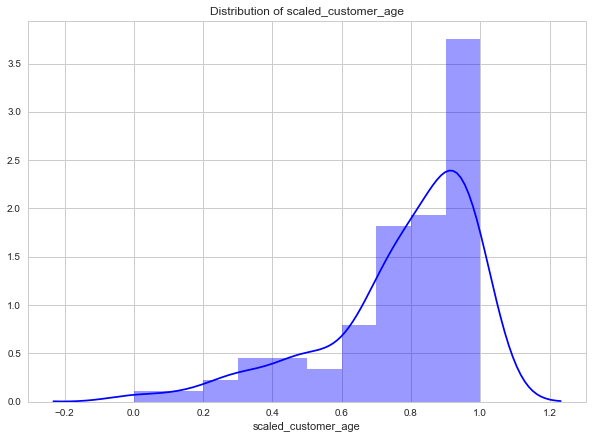

In [331]:
plt.figure(figsize=(10,7))

sns.distplot(customers_temp['scaled_customer_age'], color="blue",)
plt.title("Distribution of scaled_customer_age")

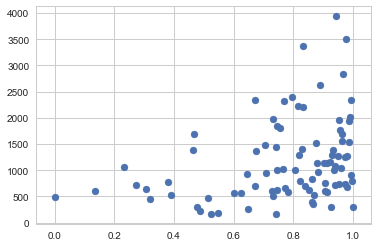

In [332]:
plt.scatter(customers_temp.scaled_customer_age, customers_temp.order_avg)

There appears to be a correlation between the age of a customer and their average order dollar size. For hypothesis test, I'll get the average order dollar amount for "older" customers and compare that to "younger" customers. Older and younger are based on how long ago the customer made their first order. I will look at some different slicing points to seperate the two groups.

In [333]:
customers_temp.describe()

,orders_count,orders_value,order_avg,scaled_customer_age
count,88.000000,88.000000,88.000000,88.000000
mean,9.420455,14382.866023,1171.198633,0.773024
std,5.774939,20278.614456,778.224550,0.219084
min,2.000000,357.000000,167.340000,0.000000
25%,5.000000,3330.700000,611.727500,0.698171
50%,8.500000,7112.230000,1005.932857,0.833624
75%,12.000000,17239.690000,1524.212750,0.939460
max,31.000000,110277.320000,3938.475714,1.000000


The oldest 25% of customers (with more than 3 orders) have a scaled_customer_age of 0.033605 or greater.
I want a more complete list of percentile values:


In [334]:
customers_temp['scaled_customer_age'].quantile([0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

0.0    0.000000
0.1    0.466376
0.2    0.647038
0.3    0.734495
0.4    0.772822
0.5    0.833624
0.6    0.880488
0.7    0.928223
0.8    0.954007
0.9    0.977875
Name: scaled_customer_age, dtype: float64

The oldest 10% of customers have a scaled_customer_age of .034921 or more.

In [335]:
customers_temp['oldest_50pct'] = np.where(customers_temp['scaled_customer_age'] >= 0.833624, True, False)
customers_temp['oldest_25pct'] = np.where(customers_temp['scaled_customer_age'] >= 0.939460, True, False)
customers_temp['oldest_10pct'] = np.where(customers_temp['scaled_customer_age'] >= 0.977875, True, False)
customers_temp.sort_values(['scaled_customer_age'])

/Users/giovanni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/giovanni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/giovanni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age,oldest_50pct,oldest_25pct,oldest_10pct
39,LACOR,La corne d'abondance,Daniel Tonini,Sales Representative,"67, avenue de l'Europe",Versailles,Western Europe,78000,France,30.59.84.10,30.59.85.11,4,1992.05,2014-01-29,2014-03-24,498.012500,0.000000,False,False,False
73,SPECD,Spécialités du monde,Dominique Perrier,Marketing Manager,"25, rue Lauriston",Paris,Western Europe,75016,France,(1) 47.55.60.10,(1) 47.55.60.20,4,2423.35,2013-11-12,2014-04-22,605.837500,0.135889,False,False,False
25,FRANR,France restauration,Carine Schmitt,Marketing Manager,"54, rue Royale",Nantes,Western Europe,44000,France,40.32.21.21,40.32.21.20,3,3172.16,2013-09-17,2014-03-24,1057.386667,0.233449,False,False,False
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,2013-08-25,2014-04-09,712.166667,0.273519,False,False,False
77,THECR,The Cracker Box,Liu Wong,Marketing Assistant,55 Grizzly Peak Rd.,Butte,North America,59801,USA,(406) 555-5834,(406) 555-8083,3,1947.24,2013-08-07,2014-04-06,649.080000,0.304878,False,False,False
89,WILMK,Wilman Kala,Matti Karttunen,Owner/Marketing Assistant,Keskuskatu 45,Helsinki,Scandinavia,21240,Finland,90-224 8858,90-224 8858,7,3161.35,2013-07-30,2014-04-07,451.621429,0.318815,False,False,False
44,LETSS,Let's Stop N Shop,Jaime Yorres,Owner,87 Polk St. Suite 5,San Francisco,North America,94117,USA,(415) 555-5938,None,4,3076.47,2013-06-25,2014-02-12,769.117500,0.379791,False,False,False
81,TRAIH,Trail's Head Gourmet Provisioners,Helvetius Nagy,Sales Associate,722 DaVinci Blvd.,Kirkland,North America,98034,USA,(206) 555-8257,(206) 555-2174,3,1571.20,2013-06-19,2014-01-08,523.733333,0.390244,False,False,False
49,MAISD,Maison Dewey,Catherine Dewey,Sales Agent,Rue Joseph-Bens 532,Bruxelles,Western Europe,B-1180,Belgium,(02) 201 24 67,(02) 201 24 68,7,9736.07,2013-05-07,2014-04-07,1390.867143,0.465157,False,False,False
31,GREAL,Great Lakes Food Market,Howard Snyder,Marketing Manager,2732 Baker Blvd.,Eugene,North America,97403,USA,(503) 555-7555,None,11,18507.46,2013-05-06,2014-04-30,1682.496364,0.466899,False,False,False


In [336]:
#get count of the oldest 50% of customers
len(customers_temp[customers_temp['oldest_50pct'] == True])

44

In [337]:
#get count of the oldest 25% of customers
len(customers_temp[customers_temp['oldest_25pct'] == True])

22

In [338]:
#get count of the oldest 10% of customers
len(customers_temp[customers_temp['oldest_10pct'] == True])

9

In [339]:
# look at the difference between mean order amounts - divide at 50%
control_mean = np.mean(customers_temp[customers_temp['oldest_50pct'] == False]['order_avg'])
treatment_mean = np.mean(customers_temp[customers_temp['oldest_50pct'] == True]['order_avg'])
actual_difference = treatment_mean - control_mean
print("Treatment mean minus control mean =", actual_difference)

Treatment mean minus control mean = 254.62375428137966


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


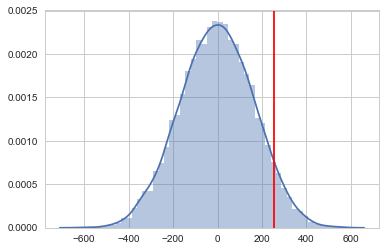

In [340]:
permutation_list = permutation_samples(customers_temp, 10000, 44, 'order_avg')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

In [341]:
# calculate p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > 222.74)
p_value = count/10000
print('P-value:', p_value)

P-value: 0.0853


In [342]:
# look at the difference between mean order amounts - divide at oldest 25%
control_mean = np.mean(customers_temp[customers_temp['oldest_25pct'] == False]['order_avg'])
treatment_mean = np.mean(customers_temp[customers_temp['oldest_25pct'] == True]['order_avg'])
actual_difference = treatment_mean - control_mean
print("Treatment mean minus control mean =", actual_difference)

Treatment mean minus control mean = 547.0964435542589


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


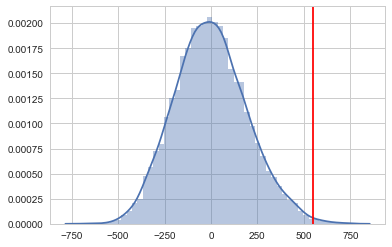

In [343]:
permutation_list = permutation_samples(customers_temp, 10000, 20, 'order_avg')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

In [279]:
# calculate p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > 578.32)
p_value = count/10000
print('P-value:', p_value)

P-value: 0.0024


In [280]:
# look at the difference between mean order amounts - divide at oldest 10%
control_mean = np.mean(customers_temp[customers_temp['oldest_10pct'] == False]['order_avg'])
treatment_mean = np.mean(customers_temp[customers_temp['oldest_10pct'] == True]['order_avg'])
actual_difference = treatment_mean - control_mean
print("Treatment mean minus control mean =", actual_difference)

Treatment mean minus control mean = 88.84456717006856


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


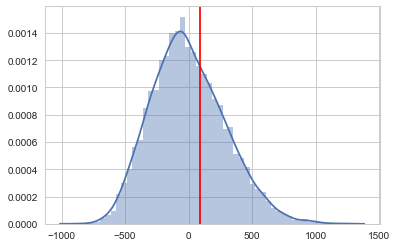

In [281]:
permutation_list = permutation_samples(customers_temp, 10000, 8, 'order_avg')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

In [282]:
# calculate p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > 88.84)
p_value = count/10000
print('P-value:', p_value)

P-value: 0.3565


Conclusions:
Probability that the observed difference in average order amount for each group compared to it's complement:
* 2.4% for the oldest 50%
* 0.38% for the oldest 25%
* 36.6% for the oldest 10%
 
Using a p-value of 0.05 (5%) for statistical signifigance:
With respect to the oldest 1/2 and oldest 1/4 of customers, the null hypothesis is rejected.
With respect to the oldest 10% of customers, the null hypothesis cannot be rejected. 

Of the groups looked at, the customers falling in the oldest 25% have the most signifigant difference in their average order value as compared to their complement. 

Further analysis would have to be performed to better understand this. Because the oldest 10% of customers do not show a signifigant p-value for average order value compared to the remaining 90%, yet they are a part of the oldest 25%, there may be some outliers in the oldest 10% that are substantially impacting that group.

In general it can be concluded the older customers make larger orders. A business recommendation could be to have policies that increase customer rentention, such as loyalty programs.

Hypothesis test #4:

Ho: There is no difference in the average orders per month for the oldest 50% of customers as compared to the youngest 50% of customers.

Ha: The average orders per month for the oldest 50% of customers is larger as compared to the youngest 50% of customers.

In [283]:
# create a column for orders/month
customers_temp['orders_per_month'] = customers_temp['orders_count'] / ((customers_temp['last_order_date'] - customers_temp['first_order_date']).dt.days/30)
customers_temp.describe()


/Users/giovanni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,orders_count,orders_value,order_avg,scaled_customer_age,orders_per_month
count,79.000000,79.000000,79.000000,79.000000,79.000000
mean,10.177215,15823.195696,1234.657549,0.028491,0.607808
std,5.613079,20927.491363,785.921221,0.007236,0.321896
min,4.000000,836.700000,167.340000,0.000000,0.215054
25%,6.000000,4174.875000,646.750833,0.026337,0.417757
50%,9.000000,9588.430000,1030.050000,0.030809,0.536585
75%,13.000000,18897.740000,1619.341603,0.033605,0.750369
max,31.000000,110277.320000,3938.475714,0.035654,2.222222


In [284]:
customers_temp.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,...,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age,oldest_50pct,oldest_25pct,oldest_10pct,orders_per_month
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,...,6,4273.00,2013-08-25,2014-04-09,712.166667,0.009752,False,False,False,0.792952
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,...,4,1402.95,2012-09-18,2014-03-04,350.737500,0.030934,True,False,False,0.225564
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,...,7,7023.98,2012-11-27,2014-01-28,1003.425714,0.026586,False,False,False,0.491803
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,...,13,13390.65,2012-11-15,2014-04-10,1030.050000,0.027331,False,False,False,0.763209
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,...,18,24927.58,2012-08-12,2014-03-04,1384.865556,0.033232,True,False,False,0.949033


In [285]:
customers_temp['orders_per_month'].quantile([0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

0.0    0.215054
0.1    0.299443
0.2    0.373634
0.3    0.448803
0.4    0.496276
0.5    0.536585
0.6    0.590757
0.7    0.697959
0.8    0.775364
0.9    0.903421
Name: orders_per_month, dtype: float64

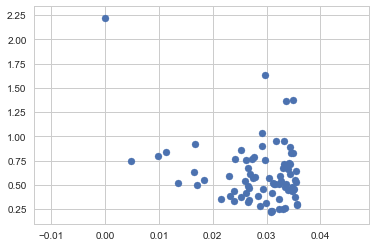

In [286]:
plt.scatter(customers_temp.scaled_customer_age, customers_temp.orders_per_month)

In [287]:
# looks like an outlier at 0.00 age and 2.25 orders/month
customers_temp.sort_values(['orders_per_month'])

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,...,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age,oldest_50pct,oldest_25pct,oldest_10pct,orders_per_month
76,THEBI,The Big Cheese,Liz Nixon,Marketing Manager,89 Jefferson Way Suite 2,Portland,North America,97201,USA,(503) 555-3612,...,4,3361.00,2012-09-20,2014-04-01,840.250000,0.030809,True,False,False,0.215054
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,...,4,1402.95,2012-09-18,2014-03-04,350.737500,0.030934,True,False,False,0.225564
17,DUMON,Du monde entier,Janine Labrune,Owner,"67, rue des Cinquante Otages",Nantes,Western Europe,44000,France,40.67.88.88,...,4,1615.90,2012-09-20,2014-02-16,403.975000,0.030809,True,False,False,0.233463
68,ROMEY,Romero y tomillo,Alejandra Camino,Accounting Manager,"Gran Vía, 1",Madrid,Southern Europe,28001,Spain,(91) 745 6200,...,5,1467.29,2012-08-14,2014-04-09,293.458000,0.033108,True,False,False,0.248756
14,COMMI,Comércio Mineiro,Pedro Afonso,Sales Associate,"Av. dos Lusíadas, 23",Sao Paulo,South America,05432-043,Brazil,(11) 555-7647,...,5,3810.75,2012-08-27,2014-04-22,762.150000,0.032300,True,False,False,0.248756
51,MORGK,Morgenstern Gesundkost,Alexander Feuer,Marketing Assistant,Heerstr. 22,Leipzig,Western Europe,04179,Germany,0342-023176,...,5,5042.20,2012-08-09,2014-03-12,1008.440000,0.033418,True,False,False,0.258621
59,PRINI,Princesa Isabel Vinhos,Isabel de Castro,Sales Representative,Estrada da saúde n. 58,Lisboa,Southern Europe,1756,Portugal,(1) 356-5634,...,5,5044.94,2012-10-23,2014-04-08,1008.988000,0.028760,False,False,False,0.281955
78,TOMSP,Toms Spezialitäten,Karin Josephs,Marketing Manager,Luisenstr. 48,Münster,Western Europe,44087,Germany,0251-031259,...,6,4778.14,2012-07-05,2014-03-23,796.356667,0.035592,True,True,True,0.287540
84,VINET,Vins et alcools Chevalier,Paul Henriot,Accounting Manager,59 rue de l'Abbaye,Reims,Western Europe,51100,France,26.47.15.10,...,5,1480.00,2012-07-04,2013-11-12,296.000000,0.035654,True,True,True,0.302419
57,PERIC,Pericles Comidas clásicas,Guillermo Fernández,Sales Representative,Calle Dr. Jorge Cash 321,México D.F.,Central America,05033,Mexico,(5) 552-3745,...,6,4242.20,2012-10-04,2014-05-05,707.033333,0.029940,False,False,False,0.311419


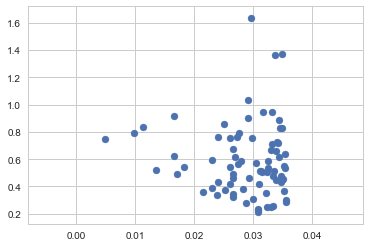

In [288]:
# I decided to drop this customer as a clear outlier. They have 4 orders in less than 2 months.
customers_temp = customers_temp[customers_temp['Id'] != 'LACOR']
plt.scatter(customers_temp.scaled_customer_age, customers_temp.orders_per_month, )

In [289]:
# look at the difference between mean order amouts
control_mean = np.mean(customers_temp[customers_temp['oldest_25pct'] == True]['orders_per_month'])
treatment_mean = np.mean(customers_temp[customers_temp['oldest_25pct'] == False]['orders_per_month'])
actual_difference = treatment_mean - control_mean
print("Treatment mean minus control mean =", actual_difference)

Treatment mean minus control mean = -0.0800960691167042


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


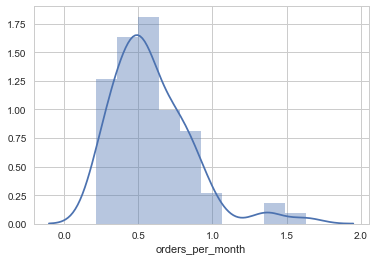

In [292]:
sns.distplot(customers_temp['orders_per_month'])

/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


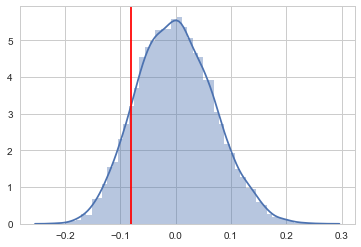

In [290]:
# run test on the oldest 50%
permutation_list = permutation_samples(customers_temp, 10000, 20, 'orders_per_month')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

In [294]:
# calculate p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > -0.080096)
p_value = count/10000
p_value

0.8763

There does not appear to be a statittically signifigant difference in the order velocity for the oldest 1/2 of customers. I cannot reject the null hypothesis.